In [75]:
import json 
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import pickle
import random

import warnings
warnings.filterwarnings('ignore')

In [77]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [79]:
stop_words = set(stopwords.words('english'))

In [81]:
lemmatizer = WordNetLemmatizer()

In [83]:
with open('intents.json') as file:
    data = json.load(file)

words = []
classes = []
documents = []

In [85]:
for intent in data['intents']:
   for pattern in intent['patterns']:

       pattern = re.sub(r'[^a-zA-Z0-9\s]', '', pattern)
       w = nltk.word_tokenize(pattern)
       words.extend(w)

       documents.append((w,intent['tag']))

       if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in stop_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

In [87]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [89]:
training = []
output_empty = [0] * len(classes)
for doc in documents:

    bag = []

    pattern_words = doc[0]

    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)


    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)

In [91]:
X = np.array([i[0] for i in training])
Y = np.array([i[1] for i in training])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [93]:
model = Sequential()
model.add(Dense(384, input_shape=(len(X_train[0]),), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(384, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(len(Y_train[0]), activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 384)            │       398,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │         3,465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,513 (2.10 MB)

 Trainable params: 549,513 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train,Y_train, epochs=200, batch_size=5, 
                    validation_data=(X_test,Y_test), callbacks=[early_stopping])

Epoch 1/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.3619 - loss: 2.2276 - val_accuracy: 0.8024 - val_loss: 0.9451
Epoch 2/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8002 - loss: 0.9114 - val_accuracy: 0.8244 - val_loss: 0.7827
Epoch 3/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9120 - loss: 0.6202 - val_accuracy: 0.8780 - val_loss: 0.6843
Epoch 4/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9443 - loss: 0.5231 - val_accuracy: 0.8634 - val_loss: 0.6686
Epoch 5/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9429 - loss: 0.4914 - val_accuracy: 0.8780 - val_loss: 0.6547
Epoch 6/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9471 - loss: 0.4344 - val_accuracy: 0.8732 - val_loss: 0.6414
Epoch 7/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9571 - loss: 0.4215 - val_accuracy: 0.8780 - val_loss: 0.6216
Epoch 8/200
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9490 - loss: 0.4120 -

In [99]:
score, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8567 - loss: 0.5964
Test accuracy: 86.83%


<Axes: >

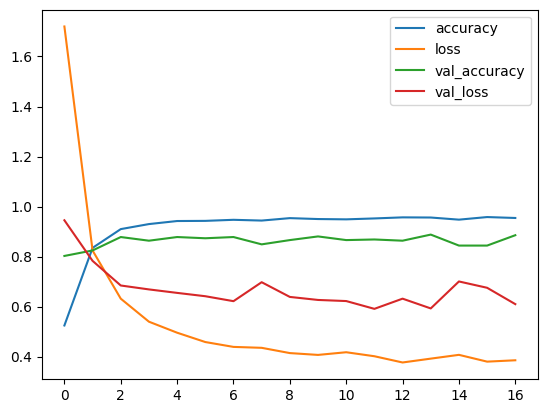

In [101]:
pd.DataFrame(history.history).plot()

In [108]:
def build_model(hp):
    model = keras.Sequential([
        layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.001, 0.01, 0.1]))),
        layers.Dropout((0.5)),
        layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.001, 0.01, 0.1]))),
        layers.Dropout((0.5)),
        layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner',
    project_name='hyperparameter_tuning'
)

tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Train with the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

Reloading Tuner from my_tuner\hyperparameter_tuning\tuner0.json
Best Hyperparameters: {'units': 384, 'l2': 0.001, 'learning_rate': 0.001}
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.2390 - loss: 2.8075 - val_accuracy: 0.5756 - val_loss: 1.7612
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6202 - loss: 1.5911 - val_accuracy: 0.7951 - val_loss: 1.0508
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8037 - loss: 1.0546 - val_accuracy: 0.8512 - val_loss: 0.8554
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8923 - loss: 0.7737 - val_accuracy: 0.8585 - val_loss: 0.7682
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9190 - loss: 0.6350 - val_accuracy: 0.8854 - val_loss: 0.7010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9492 - loss: 0.5418 - val_accuracy: 0.8854 - val_loss: 0.6898
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9465 - loss: 0.5164 - val_accuracy:

In [114]:
with open("mental_health_chatbot.pkl", "wb") as file:
    pickle.dump(model, file)